In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets,transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

In [36]:
is_cuda=False
if torch.cuda.is_available():
    is_cuda = True

In [37]:
transformation = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])

train_dataset = datasets.MNIST('data/',train=True,transform=transformation,download=True)
test_dataset = datasets.MNIST('data/',train=False,transform=transformation,download=True)

train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=32,shuffle=True)

In [38]:
sample_data = next(iter(train_loader))

In [39]:
def plot_img(image):
    image = image.numpy()[0]
    mean = 0.1307
    std = 0.3081
    image = ((mean * image) + std)
    plt.imshow(image,cmap='gray')
    
    

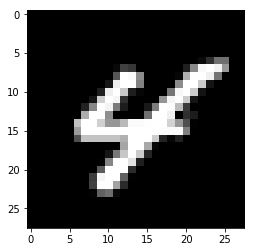

In [40]:
plot_img(sample_data[0][2])

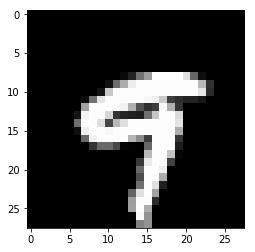

In [41]:
plot_img(sample_data[0][1])

In [110]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        #x = F.dropout(x,p=0.1, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)

In [111]:
model = Net()
if is_cuda:
    model.cuda()

In [112]:
optimizer = optim.SGD(model.parameters(),lr=0.01)

In [113]:
data , target = next(iter(train_loader))

In [114]:
output = model(Variable(data.cuda()))

In [115]:
output.size()

torch.Size([32, 10])

In [116]:
target.size()

torch.Size([32])

In [117]:
def fit(epoch,model,data_loader,phase='training',volatile=False):
    if phase == 'training':
        model.train()
    if phase == 'validation':
        model.eval()
        volatile=True
    running_loss = 0.0
    running_correct = 0
    for batch_idx , (data,target) in enumerate(data_loader):
        if is_cuda:
            data,target = data.cuda(),target.cuda()
        data , target = Variable(data,volatile),Variable(target)
        if phase == 'training':
            optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output,target)
        
        running_loss += F.nll_loss(output,target,size_average=False).data[0]
        preds = output.data.max(dim=1,keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == 'training':
            loss.backward()
            optimizer.step()
    
    loss = running_loss/len(data_loader.dataset)
    accuracy = 100. * running_correct/len(data_loader.dataset)
    
    print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)}{accuracy:{10}.{4}}')
    return loss,accuracy

In [118]:
train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]
for epoch in range(1,20):
    epoch_loss, epoch_accuracy = fit(epoch,model,train_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,model,test_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

training loss is  0.57 and training accuracy is 49446/60000     82.41
validation loss is  0.16 and validation accuracy is 9502/10000     95.02
training loss is   0.2 and training accuracy is 56571/60000     94.28
validation loss is  0.09 and validation accuracy is 9705/10000     97.05
training loss is  0.15 and training accuracy is 57471/60000     95.78
validation loss is 0.066 and validation accuracy is 9783/10000     97.83
training loss is  0.12 and training accuracy is 57865/60000     96.44
validation loss is 0.068 and validation accuracy is 9781/10000     97.81
training loss is  0.11 and training accuracy is 58032/60000     96.72
validation loss is 0.052 and validation accuracy is 9826/10000     98.26
training loss is   0.1 and training accuracy is 58190/60000     96.98
validation loss is 0.046 and validation accuracy is 9848/10000     98.48
training loss is 0.091 and training accuracy is 58407/60000     97.34
validation loss is 0.043 and validation accuracy is 9869/10000     98.69

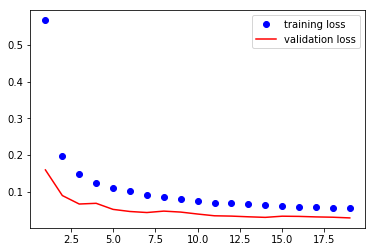

In [119]:
plt.plot(range(1,len(train_losses)+1),train_losses,'bo',label = 'training loss')
plt.plot(range(1,len(val_losses)+1),val_losses,'r',label = 'validation loss')
plt.legend()

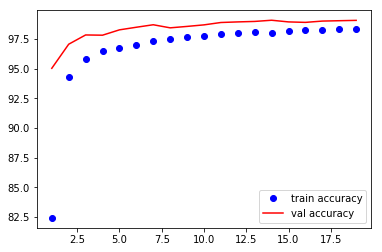

In [120]:
plt.plot(range(1,len(train_accuracy)+1),train_accuracy,'bo',label = 'train accuracy')
plt.plot(range(1,len(val_accuracy)+1),val_accuracy,'r',label = 'val accuracy')
plt.legend()

## Understanding 1d convolutions

In [71]:
conv = nn.Conv1d(1,1,3,bias=False)

In [72]:
conv.weight

Parameter containing:
(0 ,.,.) = 
  0.4587 -0.0157  0.4784
[torch.FloatTensor of size 1x1x3]

In [73]:
sample = torch.randn(1,1,7)

In [74]:
sample


(0 ,.,.) = 
  0.2512  1.2605  0.4839  1.1320 -0.3045 -0.8963  0.1234
[torch.FloatTensor of size 1x1x7]

In [75]:
conv(Variable(sample))

Variable containing:
(0 ,.,.) = 
  0.3268  1.1121  0.0585  0.0953 -0.0666
[torch.FloatTensor of size 1x1x5]

### Understand how padding works in Conv1d

In [76]:
conv = nn.Conv1d(1,1,3,padding=2,bias=False)
conv.weight

Parameter containing:
(0 ,.,.) = 
  0.1482 -0.4679  0.1801
[torch.FloatTensor of size 1x1x3]

In [77]:
sample = torch.randn(1,1,7)
sample


(0 ,.,.) = 
  0.6738 -0.1219 -0.9730  0.8453  0.2469 -0.4196  1.0974
[torch.FloatTensor of size 1x1x7]

In [78]:
conv(Variable(sample))

Variable containing:
(0 ,.,.) = 
  0.1213 -0.3373 -0.0183  0.5894 -0.4953 -0.0658  0.4306 -0.5757  0.1627
[torch.FloatTensor of size 1x1x9]